In [1]:
import numpy as np
from scipy import ndimage, misc
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
%matplotlib inline
from EMAN2 import *

In [2]:
def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    #print(x_grad)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    check = np.empty((x.ndim, x.ndim,1))
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            #print(grad_kl,"haha")
            hessian[k, l, :, :] = grad_kl      
    return hessian

def hessian_check(h):
    """
    Binarize a hessian matrix base on local convexity and return coordinates of all pixels with negative/positive definite hessian.
    Parameters:
       - h: hessian matrix output of hessian function, 
       which is an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij 
    Returns:
       a list of coordinates of pixels with negative definite hessian and list of pixels with positive definite hessian.
    """
    neg_lst=[]
    pos_lst=[]
    if len(h.shape) == 5:
        xsize=h.shape[2]
        ysize=h.shape[3]
        zsize=h.shape[4] 
        #check = np.zeros((xsize,ysize,zsize),dtype=bool)
        for i in range(xsize):
            for j in range(ysize):
                for k in range(zsize):
                    #check[i][j][k] = np.all(np.linalg.eig(h[:,:,i,j,k])[0]<0.0)
                    if np.all(np.linalg.eig(h[:,:,i,j,k])[0] < 0.0):
                        neg_lst.append((i,j,k))
                    if np.all(np.linalg.eig(h[:,:,i,j,k])[0] > 0.0):
                        pos_lst.append((i,j,k))
    else:
        xsize=h.shape[2]
        ysize=h.shape[3]
        for i in range(xsize):
            for j in range(ysize):
                if np.all(np.linalg.eig(h[:,:,i,j])[0] < 0.0):
                    neg_lst.append((i,j))
                if np.all(np.linalg.eig(h[:,:,i,j])[0] > 0.0):
                    pos_lst.append((i,j))
                
    return neg_lst,pos_lst

In [ ]:
img = imread('binarize_lowpass25.jpeg')
im = rgb2gray(img)/255
plt.imshow((im))
plt.title('slice 29')
plt.gray()
plt.show()
im.shape

In [6]:
#test_labels.shape
predicted = np.load('p2_8_test.npy').squeeze()
predicted.shape

(130, 160, 160)

In [23]:
test_data, test_labels, shape, ntrain=load_particles('particles/p2_8__bin4_preproc_test_granules_trainset.hdf',1,ncopy=1)
#test_data=normalize(test_data).reshape((-1,320,320, 1))
#test_labels.shape

130 particles loaded, 130 in training set, 0 in validation set
(130, 160, 160)
Std of particles:  0.64479977


/Users/landang/eman2-sphire-sparx/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [24]:
im = test_data.squeeze()[4]
h_im = hessian(im)
h_check=hessian_check(h_im)

In [31]:
im_b = predicted[1]
h_imb = hessian(im_b)
h_check_imb = hessian_check(h_imb)


In [15]:
#helper functions
#binarize:
def binarize(im,thres=0.0):
    """
    Binarize an image using a fixed threshold. 
    Parameters:
    -im: input image.
    -thres: a float number indicate the threshold for binarization.
    Output:
    An binarized image with all pixels with intensity > threshold set to 1.0, otherwise to 0.0
    """
    return np.argwhere(im>thres)
#xy_coor to image:
def coord_2_matrix(lst,im_size=[160,160]):
    """
    Turn a list of coordinates to a binarized image. 
    Parameters:
    -lst: list of white pixels.
    -im_size: size of desired image.
    Output:
    -an binarized image with all pixels with coordinates listed in lst to 1.0, elsewhere 0.0.
    """
    img = np.zeros(im_size)
    for i,j in lst:
        img[i,j] = 1.0
    return img

#image to xy_coor:
def matrix_2_coord(im,thres=0):
    """
    Binarize an image and turn to a list of white points. 
    Parameters:
    -im: a 2D image.
    -thres: threshold to binarize.
    Output:
    -list of xy_coordinates of all pixels of white points (points with intensity > threshold).
    """
    x,y = im.shape
    lst=[]
    for i in range(x):
        for j in range(y):
            if im[i,j]>thres:
                lst.append((i,j))
    return lst      

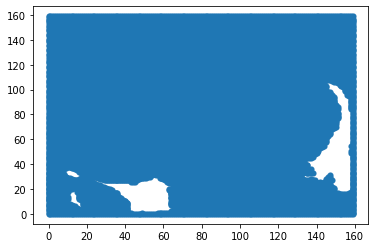

In [16]:
plt.scatter(binarize(im)[:,1][::-1],binarize(im)[:,0],marker='o',linewidths=0.1)

In [29]:
up = np.array(hessian_check(h_im)[0])
binarized = binarize(im_b,thres = 0.0)
down = np.array(hessian_check(h_imb)[1])

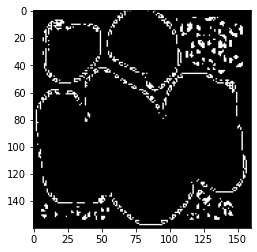

In [33]:
up = np.array(hessian_check(h_imb)[0])
plt.imshow(coord_2_matrix(up),cmap='gray')


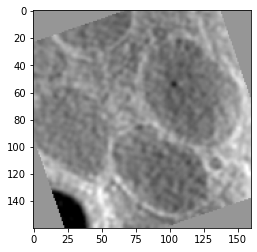

In [28]:
plt.imshow(im,cmap='gray')

In [29]:
b_up = np.array(hessian_check(h_imb)[0])
b_binarized = binarize(im_b,thres = 0.0)
b_down = np.array(hessian_check(h_imb)[1])

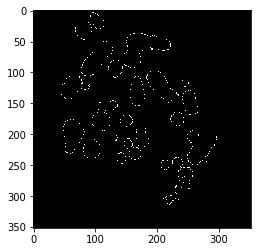

In [26]:
plt.imshow(coord_2_matrix(b_up))

In [7]:
plt.imshow(coord_2_matrix(b_down))

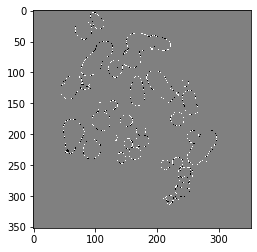

In [15]:
#show local convexity map
convex_map = coord_2_matrix(b_up)-coord_2_matrix(b_down)
plt.imshow(convex_map)

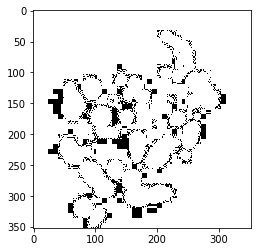

In [33]:
plt.imshow(coord_2_matrix(binarized))

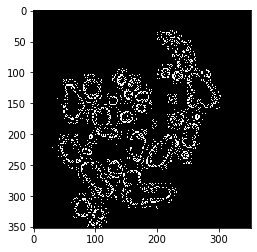

In [23]:
voted = coord_2_matrix(up)+coord_2_matrix(binarized)
voted[voted<2] = 0
voted[voted>0] = 1
plt.imshow(voted)

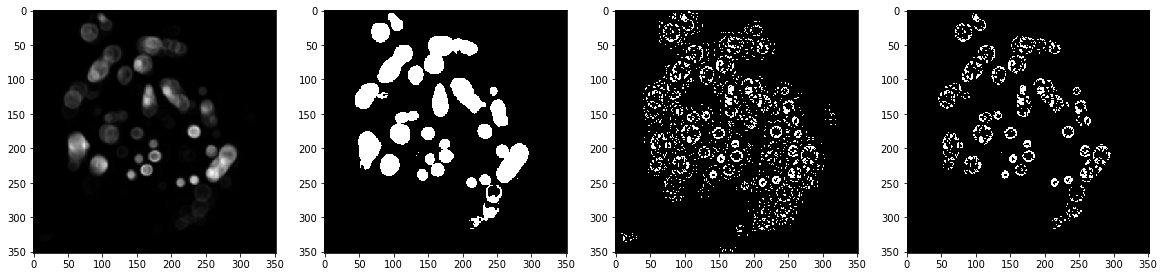

In [14]:
fig,axs = plt.subplots(1,4,figsize=(20,5))
axs[0].imshow(im)
axs[2].imshow(coord_2_matrix(up))
axs[1].imshow(coord_2_matrix(binarized))
axs[3].imshow(voted)
plt.savefig('very_cool2.png')

In [22]:
def load_particles(ptcls,labelshrink=1,ncopy=1, rng=None):
    if rng==None:
        rng=random
    num=old_div(EMUtil.get_image_count(ptcls),2)

    data=[]
    label=[]
    ntrain=-1
    for i in range(num):
        for nc in range(ncopy):
            ptl=EMData(ptcls,i*2)
            if ntrain<0 and ptl.get_attr_default("valid_set", 0)==1:
                ntrain=len(data)
            #ptl.process_inplace("threshold.belowtozero")
            if ncopy>1:
                tr=Transform()
                tr.set_rotation({"type":"2d","alpha":rng.random()*360.0})
                ptl.process_inplace("xform",{"transform":tr})

            ar=ptl.numpy().copy()
            #shp=np.shape(ar)
            data.append(ar)
            
            ptl=EMData(ptcls,i*2+1)
            #ptl.process_inplace("threshold.belowtozero")
            if ncopy>1:
                ptl.process_inplace("xform",{"transform":tr})
            if labelshrink>1:
                ptl.process_inplace("math.meanshrink",{'n':int(labelshrink)})
            ar=ptl.numpy().copy()
            #shp=np.shape(ar)
            label.append(ar)

    if ntrain<0: ntrain=len(data)
    print("{:d} particles loaded, {:d} in training set, {:d} in validation set".format(len(data), ntrain, len(data)-ntrain))
    data=np.asarray(data,dtype=np.float32)
    
    print(data.shape)
    print("Std of particles: ",np.std(data))
    #data/=np.std(data.flatten())*3  #np.max(np.abs(data))
    data/=3. ### so the range is roughly (-1,1)
    label=np.asarray(label,dtype=np.float32)
    label/=np.max(np.abs(label))
    
    header=EMData(ptcls,0,True)
    shape=[header["nx"],header["ny"],header["nz"]]
    return data, label, shape, ntrain

In [15]:
import h5py
def traverse_datasets(hdf_file):
    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'
            if isinstance(item, h5py.Dataset): # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group): # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    for path, _ in h5py_dataset_iterator(hdf_file):
        yield path

In [16]:
with h5py.File('6set.hdf', 'r') as f:
    for dset in traverse_datasets(f):
        im_stack = np.array(f[dset])
        print('Path:', dset)
        print('Shape:', f[dset].shape)
        print('Data type:', f[dset].dtype)
        

Path: /MDF/images/0/image
Shape: (64, 352, 352)
Data type: float32


In [17]:
print(im_stack.shape)
hs=hessian(im_stack)
hs_check=hessian_check(hs)

(64, 352, 352)


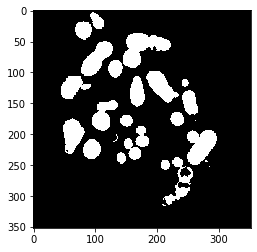

In [18]:
#plt.imshow((im_stack[29][:][:]))
plt.imshow(coord_2_matrix(binarize(im_stack[29],thres=0.3)))

In [19]:
point_lst = (hs_check[0])
print(len(point_lst))
from collections import defaultdict
#a dictionary with slice number as key and image as value.
d = defaultdict(list)
#binary hessian result for the image stack.
hessian_stack = np.zeros([64,352,352])
for k, *v in point_lst:
    d[k].append(v)
for i in range(64):
    hessian_stack[i]=coord_2_matrix(d[i]) 
#list(d.items())

155630


In [21]:
hessian_stack_EM = from_numpy(hessian_stack)
hessian_stack_EM.write_image('6set_hessian_stack.hdf')

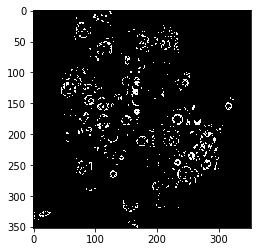

In [22]:
plt.imshow(coord_2_matrix(d[29]))
plt.imshow(hessian_stack[29])

In [23]:
with h5py.File('6set_hessian_neg.hdf', 'w') as f:
    dset = f.create_dataset("MDF/images/0/image",data=hessian_stack)
    

In [24]:
with h5py.File('6set_Li_thresholding.hdf', 'r') as f:
    for dset in traverse_datasets(f):
        b_stack = np.array(f[dset])
        print('Path:', dset)
        print('Shape:', f[dset].shape)
        print('Data type:', f[dset].dtype)


Path: /t0/channel0
Shape: (64, 352, 352)
Data type: uint8


In [25]:
b_stack=b_stack/255
voted_stack= np.zeros([64,352,352])
for i in range(64):
    voted=hessian_stack[i]+b_stack[i]
    voted[voted<2] = 0
    voted[voted>0] = 1
    voted_stack[i]=voted

In [26]:
voted_stack_EM = from_numpy(voted_stack)
voted_stack_EM.write_image('6set_voted_stack.hdf')

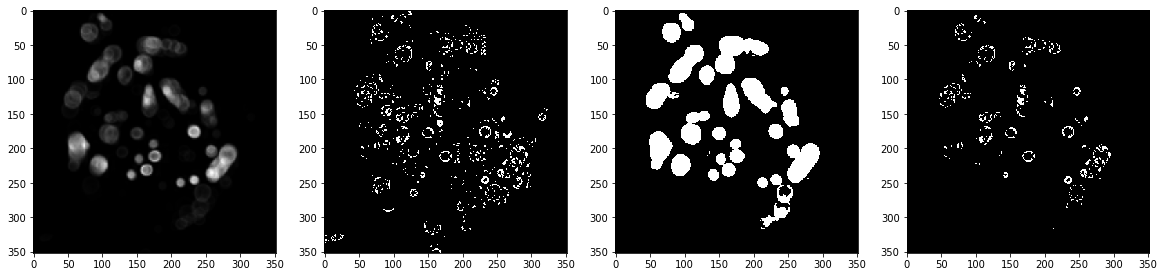

In [143]:
def plot_voted(im_slice=0):
    fig,axs = plt.subplots(1,4,figsize=(20,5))
    axs[0].imshow(im_stack[im_slice])
    axs[1].imshow(hessian_stack[im_slice])
    axs[2].imshow(b_stack[im_slice])
    axs[3].imshow(voted_stack[im_slice])
plot_voted(29)

In [144]:
from EMAN2 import *

ImportError: dlopen(/Users/landang/miniconda3/envs/cloneenv/lib/python3.7/site-packages/libpyEMData2.so, 2): Symbol not found: __ZN4EMAN6EMData22calc_max_location_wrapEiii
  Referenced from: /Users/landang/miniconda3/envs/cloneenv/lib/python3.7/site-packages/libpyEMData2.so
  Expected in: flat namespace
 in /Users/landang/miniconda3/envs/cloneenv/lib/python3.7/site-packages/libpyEMData2.so

In [283]:
from scipy import ndimage
from skimage import morphology
closed = ndimage.binary_closing(voted,iterations=2)
labeled = morphology.label(closed,connectivity=2)
a = [morphology.convex_hull_image(labeled == i) for i in list(set(labeled.ravel()))[1:] if np.sum(labeled==i)>50] 

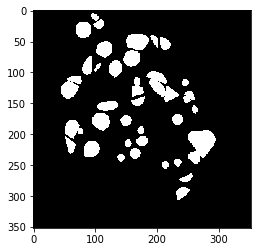

In [284]:
b = np.sum(np.stack(a),axis=0)
plt.imshow(b>0)

In [308]:
from sklearn.cluster import DBSCAN
from collections import Counter
f = DBSCAN(eps=10,min_samples=5)
a = f.fit_predict(np.argwhere(binarized))
print(Counter(a))
#np.argwhere(a==)

Counter({0: 35464})


In [306]:
plt.imshow(coord_2_matrix(np.argwhere(voted)[a==6]))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5374 but corresponding boolean dimension is 35464

In [309]:
binarized

array([[123,  45],
       [124,  45],
       [125,  45],
       ...,
       [207, 296],
       [208, 296],
       [209, 296]])

In [32]:
h_im = hessian(im)
def binarize(im,thres=0.0):
    coor = []
    for col in range(im.shape[0]):
        for row in range(im.shape[1]):
            if im[row][col] > thres:
                coor.append((row,col))
    #len(coor)
    xy_coor = np.array(coor)  
    return xy_coor
def hessian_check2(h):
    xsize=h.shape[2]
    ysize=h.shape[3]
 
    #check = np.zeros((xsize,ysize),dtype=int)
    lst = []
    count = 0
    for i in range(xsize):
        for j in range(ysize):
            if np.all(np.linalg.eig(h[:,:,i,j])[0] < 0.0):
                #print(i,"and",j, "is",np.linalg.eig(h[:,:,i,j])[0])
                lst.append((i,j))
            #if np.all(np.linalg.eig(h[:,:,i,j])[0]<0):
                #check[i][j] = 1
            #else:
                #check[i][j] = 0
    return(lst)

In [298]:
np.random.seed(1234)
m = np.random.randn(3, 3, 3)
hessian(m)

array([[[[[ 3.13898163e+00, -2.51897635e+00, -3.76915700e-01],
          [-1.43763475e+00,  1.75767114e+00,  1.05437829e+00],
          [ 1.08675162e+00, -9.58367806e-01,  5.65332876e-02]],

         [[ 3.13898163e+00, -2.51897635e+00, -3.76915700e-01],
          [-1.43763475e+00,  1.75767114e+00,  1.05437829e+00],
          [ 1.08675162e+00, -9.58367806e-01,  5.65332876e-02]],

         [[ 3.13898163e+00, -2.51897635e+00, -3.76915700e-01],
          [-1.43763475e+00,  1.75767114e+00,  1.05437829e+00],
          [ 1.08675162e+00, -9.58367806e-01,  5.65332876e-02]]],


        [[[ 3.98009614e+00, -3.64167751e+00, -7.80479360e-01],
          [ 9.28325034e-01, -6.49517252e-01,  3.57078257e-01],
          [-2.12344607e+00,  2.34264300e+00,  1.49463587e+00]],

         [[-5.96520238e-01,  6.34969984e-01,  6.50814632e-01],
          [-9.77899720e-02,  1.30787020e-01,  5.73802752e-01],
          [ 4.00940294e-01, -3.73395945e-01,  4.96790871e-01]],

         [[-5.17313662e+00,  4.91161747e+00

In [272]:
hessian_check(h)

array([[[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]]])

In [184]:
a = np.array([[1,2,3],[2,3,1],[3,2,1]])
b= np.array([[0,1],[-2,-3]])
c= np.array([[0,1],[1,0]])
m = np.array([[[1, 2, 2], [3, 4, 4],[5, 6, 6]], 
              [[5, 6, 6], [7, 8, 8],[9, 10, 10]],
             [[1,1,2],[2,2,3],[3,3,4]]])

#np.linalg.eig(b)

mgr = np.gradient(m)
eig = np.linalg.eig(m)
for i in eig[0].flatten():
    if i < 0: print(i)



-0.5207972893961469
-5.17264007533972e-16
-0.2579760163048481
-8.367889512728896e-16
-0.4051248379533272
-6.111634215249674e-16


In [116]:
def hessian_check(a):
    hessian = np.empty(a.shape)
    for i, grad_i in enumerate(np.gradient(a)):
        #print(i)
        #print(grad_a)
        #print(grad_a.shape)
        temp = np.gradient(grad_a)
        for j,grad_j in enumerate(temp):
            hessian[i,j,:]=grad_j
    return hessian
        
        
hessian_check(m)      
    

ValueError: could not broadcast input array from shape (3,3,3) into shape (3)

In [139]:
up

array([[  2, 106],
       [  2, 107],
       [  3, 106],
       ...,
       [349, 170],
       [350, 169],
       [351, 169]])

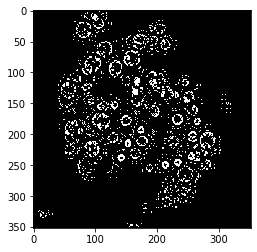

In [170]:

a = np.zeros([352,352])
for i,j in up:
    a[i,j] = 1.0

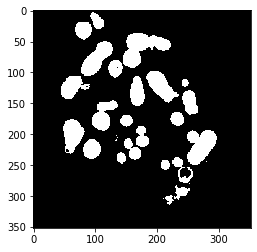

In [171]:
plt.imshow(im_b)

In [155]:
up

(8568, 2)

In [58]:
for col in range(4):
    for row in range(3):
        print(a[row][col])

1
4
7
2
5
8
3
6
9
10
11
12


In [114]:
a = [1,2,3]
a[::-1]

[3, 2, 1]